In [0]:
# importing libraries
from autograd import numpy as np
from autograd import grad
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd.misc.optimizers import adam
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import sklearn as sk
from math import *
from pylab import rcParams
import random
from PIL import Image
import time
import sys 
import scipy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# AM 207 Final Project: What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?
Eric Sun, Shangda Xu
\
Professor Weiwei Pan
\
TF: Meng

## Overview

### Problem Statement

This paper tries to model uncertainty, both aleatoric and epistemic, in Bayesian deep learning, specifically for computer vision applications. It aims to use this to increase prediction accuracy, which is the primary metric for comparing their models to previous ones. Uncertainty is particularly important in cases where the confidence machine learning predictions is imperative, such as for drug dosage recommendations and actions for autonomous vehicles where accurate measurements of uncertainty may potentially save lives.

### Context and Scope

So far, existing Bayesian deep learning models have only captured one of epistemic and aleatoric uncertainty by formalizing probability distributions over the model parameters or outputs. For example, they model epistemic uncertainty with a prior distribution over a model's weights and attemept to capture variation in the weights given some data. Aleatoric uncertainty is computeed using a distribution over the model output. This paper attempts to combine both aleatoric and epistemic uncertainty in one model - we discuss both below, as well as the specific technical details of the model the authors implement.

They do so for a computer vision model. This is an extremely interesting context to do this work in, and provides several useful insights if successful. Understanding uncertainty and classifying it correctly helps us and the decision making algorithm know what it does not know. In vision models in particular, which can be used in many high stakes contexts, mistakes can be disastrous. For example, an assisted driving system crashed and caused a fatality because it misidentified a trailer as athe sky in May 2016. Given the introduction of more and more automated cars running computer vision models on the street, knowing the level of certainty is extremely important.

Even beyond this, many potential applications of deep learning have similar requirements. If a doctor identifies someone's affliction with 10\% uncertainty, that person would be far more comfortable with proposed treatments than if the identification had 90\% uncertainty. The doctor may also not want to propose treatments in the second scenario. Thus, understanding, categorizing, and knowing uncertainty is important.

This paper attempts to fill this gap, both by trying to introduce a measure of epistemic and aleatoric uncertainty in a novel combined model, but using said model to make more accurate predictions.

### Existing Work

As mentioned above, existing Bayesian deep learning models have been able to capture one of epistemic and aleatoric uncertainty in models. We discuss both here.\\

For epistemic uncertainty in a neural net, a prior distribution over weights is used and called a Bayesian neural net. This approach is taken in Denker and LeCun 1991, MacKay 1992, and Neal 1995. Specifically, we replacing the parameters themselves with distributions over parameters, and averaging over all weights rather than just optimizing the weights directly. Bayesian infeerence is then used to compute the posterior over weights as $p(W | X, Y)$ given some dataset $X, Y$. A challenge with BNNs is the difficulty of performing inference, since the marginal probability requires the evaluation of the posterior, which cannot be evaluated analytically. Graves 2011, Blundeell et al. 2015, Hernández-Lobato et al. 2016, and Gal and Ghahramani 2016 all propose different methods of estimation, with the key idea being fitting a simple distribution to the posterior parametrized by some $\theta$, thus replacing our intractablee problem with some optimization task. One approach to this is dropout variational inference, which the authors use in this paper - we discuss this more below, so omit discussion here. Overall, the classification of epistemic uncertainty, which is that which can be reduced by more data, can be done usiing Monte Carlo integration as:
$$p(y = c | x, X, Y) \approx \frac{1}{T} \sum_{t = 1}^T \text{Softmax} (f^{\bar{W}_t}(x))$$
with T sampled masked model weights $\bar{W}_t \~ q^*_{\theta}(W)$. In regression, we have epistemic uncertainty captured by predictive variance:
$$\text{Var}(y) = \sigma^2 + \frac{1}{T} \sum_{t = 1}^T f^{\bar{W}_t}(x)^T f^{\bar{W}_t}(x) - E(y)^TE(y)$$
where the $\sigma^2$ term is noise inherent in the data and the rest is a term that will vanish with 0 parameter uncertainty.\\

Existing work also includes that on aleatoric uncertainty, specifically heteroscedastic aleatoric uncertainty. This assumes that observation noise can vary with $x$, which is explored in Nix and Weigend 1994 and Le et al. 2005. When data-dependent, it can be learned as:
$$\mathcal{L}_{NN}(\theta) = \frac{1}{N} \sum_{i = 1}^N \frac{1}{2\sigma(x_i)^2} ||y_i - f(x_i)||^2 + \frac{1}{2} \log \sigma(x_i)^2$$

As mentioned above, this paper attempts to meld this prior work into one that uses both uncertainties.

### Contribution

The authors' contribution to the literature is primarily in proposing a combined model of aleatoric and epistemic uncertainty that is based on the previously outlined independent models of either form of uncertainty. In their approach, epistemic uncertainty can be modeled alone, aleatoric uncertainty can be modeled alone, or both types of uncertainty can be modeled together. The authors also make the observation that aleatoric uncertainty can be interpreted as learned loss attenuation where the inclusion of the aleatoric term in the loss function makes it more robust to noise in the data. This is one of the explanations behind the higher classification accuracy that the authors observed in their experimental setups.

## Technical content

### High Level

To model epistemic uncertainty (i.e. uncertainty from lack of data), the authors place a distribution over the NN weights $W$. In doing so, the training becomes a problem of approximating the posterior distribution of $W$ in BNN instead of simply finding the the maximum likelihood estimates of $W$ as is usually done for a NN. Since the posterior distribution of the BNN highly non-convex, the authors approximate the posterior using dropout as variational inference. The authors implement dropout as setting some weights to zero with probability $p$ at each training iteration, where $p$ is optimized during training. As a result, the authors obtain trained weights from an ensemble of BNNs. To model aleatoric uncertainty, the authors make the general assumption of heteroscedastic uncertainty in that the intrinsic uncertainty of the model is a function of the input $x$. The uncertainty $\sigma (x)$ is included in the loss function of the BNN. Intuitively, the authors' loss functions forces the network to find the optimal weights that provide the best prediction $\hat{y}(x)$ but also the variance $\sigma^2(x)$ for every input $x$, which reflects the intrinsic noise in the data.

### Details

The authors use dropout as variational inference in training their BNN. According to the authors, dropout is equivalent to variational inference with the approximating distribution being the mixture of two low-variance Gaussians with one of them centered at the origin. The dropout consists of masking a set of weights to be zero at each training iteration with proabibility $p$ where $p$ is optimized according to the loss function:

$$ L(\theta, p) = -\frac{1}{N} \sum_{i=1}^N \log p(y_i | f^{\hat{W}_i}(x_i)) + \frac{1-p}{2N} ||\theta ||^2$$

This is the same loss function that is applied explicitly to the epsitemic-only BNN model for uncertainty and is also implicit in the training for the combined model, which we will discuss in greater detail later. Here $\theta$ refers to the distribution parameters and $p$ is the probability of dropout. As we can see, the dropout training involves optimizing both the weights and $p$ and $\theta$ through a regularization term.

The combined model must include loss terms that allow for epistemic uncertainty (i.e. uncertainty due to lack of data) and aleatoric uncertainty (i.e. uncertainty in the model). To model epistemic uncertainty, we can turn the NN into a BNN by placing a distribution over each of the weights. Likewise, we can model aleatoric uncertainty by taking the general case of heteroscedastic aleatoric uncertainty, which models $\sigma^2(x)$ as a function of $x$ instead of being restricted to a constant. These two modifications are exactly like the modifications that were made in the previously outlined models where only one type of uncertainty was investigated. The loss function is of the same log Gaussian form:

$$ L_{BNN} (\theta )= \frac{1}{D} \sum_i \frac{1}{2} \hat{\sigma}_i^{-2} || y_i - \hat{y_i} ||^2 + \frac{1}{2} \log \hat{\sigma}_i^2 $$

$D$ denotes the mapping dimension of the BNN, which in the case of our toy polynomial example is just $D=1$ since one value of $x$ maps to one value of $y$. Since the log variance is more numerically stable, we can rewrite the objective function in the form:

$$ L_{BNN} (\theta )= \frac{1}{D} \sum_i \frac{1}{2} \exp(-s_i) || y_i - \hat{y_i} ||^2 + \frac{1}{2} s_i $$

Thus, the only substantial change we need to make to our choice of a BNN is to implement this objective function and sample both the predictions $y_t$ and the log variance $s_t$, where $t$ indexes a sample from $T$ total samples. For the BNN denoted $f_W(x)$, this means that:

$$ [y, s] = f_{\hat{W}}(x) $$

where $\hat{W}$ is the approximate posterior obtained through dropout variational inference.

Finally, we can approximate the predictive uncertainty for a given output $y$ using Monte Carlo estimation as:

$$ \text{Var}(y) \approx \frac{1}{T} \sum_{t=1}^T \hat{y}_t^2 - \left( \frac{1}{T} \sum_{t=1}^T \hat{y}_t \right)^2 + \frac{1}{T} \sum_{t=1}^T \sigma_t^2$$

Note that this MC computation is rather computationally expensive so in real-time applications where uncertainty calculation time is important, we may prefer to compute aleatoric uncertainty alone.

With these theoretical underpinnings outlined, we will implement the model used by the authors:

1. Add a distribution over neural network weights $W$ to make a BNN
2. Modify BNN to return outputs of prediction $y$ and log variance $s$ (this is achieved through a two-dimensional output matrix)
3. Implement the author's objective function with the variance and regularization term.
4. Sample from the BNN posterior using different methods to compare:
    - Dropout Variational Inference (used by authors)
    - Hamiltonian Monte Carlo
    - Black-box Variational Inference
    
The authors also outline the aleatoric uncertainty as learned loss attenuation in classification tasks. The analogy is that by introducing $s_i$ as a variable to predict, the neural network is essentially learning how to account for uncertainty with respect to the data and task.

## Methodology and Discussion

### Experiments

Since the authors are working on computer vision, they evaluate their methods with pixel-wise depth regression and semantic segmentation. As mentioned above, their network is based on DenseNet, which is adapted for dense prediction tasks, with a TensorFlow-based implementation of the architecture.<br>

For all experiments, the architecture is first trained with 224x224 crops of batch size 4, then fine-tuned on full size images with batch size 1. Training is done with RMS-Prop with a constant learning rate of 0.001 and weight decay $10^{-4}$.<br>

Within the experiments, epistemic uncertainty is modeled using Monte Carlo dropout; they place dropout with $p = 0.2$ after each convolutional layer, with 50 Monte Carlo dropout samples. Aleatoric uncertainty is modeled with MAP inference using loss functions derived using a Laplacian prior, since this prior results in a loss function which applies a L1 distance on the residuals, which usually outperforms L2 loss for regressiont tasks in vision. Per one of the key goals of the paper, the authors also combinee both epistemic uncertainty as well as aleatoric uncertainty using their developments, trying to demonstrate benefit.<br>

We first discuss experiments with semantic segmentation. The authors use two datasets, CamVid and NYU v2. CamVid is a road scene understanding dataset with 367 training images and 233 test images of day and dusk scenes, with 11 classes. These are resized to 360x480 pixels for training and evaluation. For each model, the authors run the dataset through the architecture for the purpose of segmenting the road scene. They report the mean intersection over union over the dataset, showing results for existing work (highest IoU score is DenseNet, with 66.9% IoU) as well as novel architecture - the independent implementation of DenseNet resulted in a 0.2% increase, adding only aleatoric uncertainty resulted in an incremental 0.3% increase, adding only epistemic uncertainty resulted in an incremental 0.1% increse, and adding both resulted in an incremental 0.4% increase for a total 67.5% IoU score, which the authors claim is state of the art<br>

NYU v2 is a challenging indoor segmentation dataset with 40 different semantic classes with  1449 images with resolution 640 × 480 from 464 different indoor scenes. Since there is significantly less structure in indoor scenes compared to street scenes and the increased number of semantic classes, this is more challenging. Unsurprisingly, IoUs are lower, but improvements are larger. The independently implemented model resulted in an incremental increase of 2.4%， adding only aleatoric uncertainty resulted in an incremental 0.6% increase, adding only epistemic uncertainty resulted in an incremental 0.2% increse, and adding both resulted in an incremental 0.8% increase for a total 37.3% IoU score. Additionally, on a measure of accuracy, the independently implemented model resulted in an incremental increase of 4.5%， adding only aleatoric uncertainty resulted in an incremental 0.3% increase, adding only epistemic uncertainty resulted in an incremental 0.1% increse, and adding both resulted in an incremental 0.5% increase for a total 70.6% accuracy.<br>

For pixel-depth regression, the authors use Make3D and NYUv2 Depth. They run through the architectures, which show improvements for the combined model, as well as that aleatoric uncertainty is able to capture many aspects of this task which are inherently difficult, whiile epistemic uncertainty captures difficulties due to lack of data.<br>

The key claim the authors try to prove is that their model incorporating uncertainty has increased accuracy compared to current models. This claim is mostly proven, although the increase in IoU or accuracy scores attributable to the inclusion of uncertainty is not large. The secondary claim the authors make is that they are able to classify the two types of uncertainty effectively. This claim is slightly more dubious. They offer some qualitative support: aleatoric uncertainty is greater for large depths, reflective surfaces and occlusion boundaries in the images, which are common failure modes of monocular depth algorithms; epistemic uncertainty is greater for objects which are rare in the training set such as humans.

### Evaluation

We believe that the authors' modeling of epistemic and aleatoric uncertainty is technically sound since the model combines previously developed methods for modeling those uncertainties into one model. The derivation of the loss function in the aleatoric model is justified since it is resemblant of a log Gaussian likelihood form with a regularization term. The epistemic model captures the variance in the distributions over the weights and provides fairly reliable epistemic uncertainty measurements as we noted on Problem Set 7 and 8. There are no obvious mathematical errors in either of the approaches. However, the authors' choice of dropout variational inference may be technically questionable as there has been recent controversy surrounding the proof of dropout as a form of variational inference [1]. As such, we opt to use black-box variational inference (BBVI) and Hamiltonian Monte Carlo (HMC) instead of dropout variational inference to avoid potential problems here. The results of our project (as depicted below) further support the paper's model as one that is able to capture the total uncertainty in regression tasks quite well. For example, heteroscedastic aleatoric uncertainity can be captured remarkably well even when the underlying noise $\epsilon(x)$ is nonlinear. Additionally, the epistemic uncertainty blows up in data-sparse regions and shrinks in data-dense regions, which respects our intuitive notion of data-dependent uncertainty.

We believe the combined uncertainty model is quite practical. This practicality is evident in the remarkable and efficient performance of the model on our toy polynomial regression examples. In the paper, the authors also show that the model can be practically applied to higher-dimensional image pixel-wise depth regression tasks and image semantic segmentation tasks, which are perhaps more reflective of real-world tasks than polynomial regression. The authors' tasks are also computationally intensive, which suggests that many current applications of NN models can be adapted for the combined uncertainty model given sufficient computing resources. This is especially true given the general nature of the combined uncertainty model, which only modifies the loss function and the outputs of a BNN. As a result, the model is not dependent on the actual architecture of the network or the nature of the data and can likely be applied to a wide range of tasks. Using GPU acceleration, the authors were able to make dropout variational inference economically feasible for neural networks like ResNet where only the last few layers require dropout. However, some neural network models like DenseNet where every layer requires dropout may experience significant slowdown in the MC calculations. Switching from dropout VI to BBVI or HMC may provide alternative design choies that can potentially speed up computation for specific tasks.

The authors provided two main examples in their experimental section: pixel-wise depth regression and image semantic segementation. Although both of these tasks fall under computer vision, they present two different challenges and objectives. Pixel-wise depth regression is a regression method over the spatial component of the pixels that is used in image analysis tasks. On the other hand, image semantic segmentation is mostly a classification problem that is more concerned with global spatial segments rather than local correlations between pixels. Since the model increases predictive accuracy in both cases over the current state-of-the-art, this provides strong evidence that the model is fulfilling its goal of representing uncertainty. To further increase our confidence in the authors' model, it may be necessary to explore example tasks outside of computer vision. In this project, we look at polynomial regression and show that the uncertainty is captured qualitatively through the model. Other examples may include medical diagnosis or drug dosage recommendation from patient data, which are classification and regression problems that are of great interest in the clinical sciences. However, given the typical scope of a paper, we believe that the authors provided sufficient evidence that there is potential for their model to be generalized to a wide variety of tasks. In this project, we explore polynomial regression, which lends well to visualizing the uncertainties obtained through the model. We notice that these uncertainties align well with our intuitive understanding of uncertainty and so the improved performance noted by the authors is unlikely to have been due to confounds.

However, the central question of what is the best way to model uncertainty is still open. The authors provide their own model and justify it, but there are certainly alternative approaches for modeling uncertainty that may have greater performance in certain tasks.


References:

[1] Yarin Gal and Zoubin Ghahramani. Bayesian convolutional neural networks with Bernoulli approximate
variational inference. ICLR workshop track.

### Future Work

The modeling of uncertainty in deep learning models is increasingly important as more and more applications exist and products like facial recognition software or self-driving cars hit the streets. These provide significant cases where identifying and segregating types of error will be useful. While computer vision is an especially important consideration, many other things also need to consider this kind of separation. For example, Goldman Sachs' recent debacle regarding its credit card discriminating against women by accident is an example of poor algorithm understanding.

In the future, then, we and the authors hope to continue similar work along these veins to further identify and account for error more accurately.

## Code

In this project, we will be implementing the combined uncertainty model as well as the aleatoric and epistemic-only uncertainty models. The toy task that we will explore is polynomial regression. This choice was made due to its computational efficiency; other more computationally intensive tasks such as image classification or pixelwise depth regression were not as feasible on our computers. The authors used dropout variational inference, but we chose to utilize BBVI in our design instead (checked with Wei Wei). Both methods accomplish the same goal which is to approximate the posterior using a variational distribution family. 

### Toy Problem:

Our toy problem will be polynomial regression with the function determined by the coefficients listed below. Samples are collected from the model with some noise (i.e. to test aleatoric uncertainty of the NN model).

In [0]:
def poly(x, coeffs, noise): # function for making our toy polynomial
    polys = []
    for i, xd in enumerate(x):
        summed = np.sum([coeffs[i]*xd**i for i in range(len(coeffs))])
        noised = summed + np.random.normal(0,noise[i])
        polys.append(noised)
    return (np.array(polys))

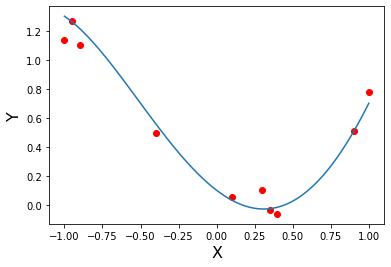

In [0]:
x = np.array([-1,-0.95,-0.9,-0.4,0.1,0.3,0.35,0.4,0.9,1])
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.1*np.ones(len(x)));

x_space = np.linspace(-1,1,100)
y_space = poly(x_space, coeffs, np.zeros(len(x_space)))

plt.plot(x,y,'ro',linewidth=0,label='samples')
plt.plot(x_space,y_space,label='samples')
plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.show()

### Modeling Epistemic Uncertainty
To model epistemic uncertainty, the authors place a distribution over each of the weights of the NN. In essence, this converts the standard NN to a Bayesian NN (BNN). We will use the same architecture as in a previous problem set:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}

In [0]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_data, y_data, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_data - self.forward(W, x_data), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_data - self.forward(W, x_data), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_data, y_data, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_data.shape[0] == self.params['D_in']
        assert y_data.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_data, y_data, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 1000
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [0]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

We generate data that is clustered to showcase epistemic error:

In [0]:
x = np.array([-0.9, -0.85, -0.8, 0, 0.05, 0.1, 0.7, 0.75, 0.8, 0.85])
y = poly(x, coeffs, 0.1*np.ones(len(x)));

In [0]:
###define design choices in gradient descent
params = {'step_size':5e-3, 
          'max_iteration':10000, 
          'random_restarts':1,
          'check_point':1000}

nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)
w = nn.weights

Iteration 0 lower bound 0.07498717624784411; gradient mag: 3.861606961114282
Iteration 1000 lower bound 0.035913332035842696; gradient mag: 0.005756567796394261
Iteration 2000 lower bound 0.029651977988137936; gradient mag: 0.009060795573894482
Iteration 3000 lower bound 0.005097286134933507; gradient mag: 0.001225615535309731
Iteration 4000 lower bound 0.004834728895164687; gradient mag: 0.0011730887340904118
Iteration 5000 lower bound 0.004598215930104482; gradient mag: 0.0011227951656660874
Iteration 6000 lower bound 0.004361819892904857; gradient mag: 0.0011109583732901564
Iteration 7000 lower bound 0.004091716584634059; gradient mag: 0.0011764844822315555
Iteration 8000 lower bound 0.0037206251217784805; gradient mag: 0.001391715932165649
Iteration 9000 lower bound 0.0030136082136337193; gradient mag: 0.0019541519623400036


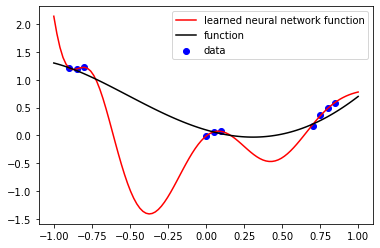

In [0]:
x_range = np.linspace(-1,1,100)
y_pred = nn.forward(nn.weights, x_range.reshape((1, -1)))
plt.scatter(x, y, color='blue', label='data')
plt.plot(x_range, y_pred.flatten(), color='red', label='learned neural network function')
plt.plot(x_space, y_space, color='black', label='function')
plt.legend(loc='best')
plt.show()

#### HMC

Here we will use Hamiltonian Monte Carlo (HMC) as the sampling method (instead of dropout as the authors used). The problem is the same as the polynomial above.

In [0]:
class HMC:

    def __init__(self, potential_energy, kinetic_energy, kinetic_energy_distribution, random=None, diagnostic_mode=False):
        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)
        self.D = np.max(kinetic_energy_distribution(1).shape)
        self.potential_energy = potential_energy
        self.kinetic_energy = kinetic_energy
        self.total_energy = lambda position, momentum: potential_energy(position) + kinetic_energy(momentum)

        self.sample_momentum = lambda n: kinetic_energy_distribution(n).reshape((1, self.D))
        self.grad_potential_energy = grad(potential_energy)

        self.params = {'step_size': 0.1,
                       'leapfrog_steps': 10,
                       'total_samples': 1000,
                       'burn_in': 0.1,
                       'thinning_factor': 1,
                       'diagnostic_mode': diagnostic_mode}

        self.accepts = 0.
        self.iterations = 0.
        self.trace = np.empty((1, self.D))
        self.potential_energy_trace = np.empty((1,))

        assert self.sample_momentum(1).shape == (1, self.D)
        assert isinstance(self.potential_energy(self.sample_momentum(1)), float)
        assert isinstance(self.kinetic_energy(self.sample_momentum(1)), float)
        assert isinstance(self.total_energy(self.sample_momentum(1), self.sample_momentum(1)), float)
        assert self.grad_potential_energy(self.sample_momentum(1)).shape == (1, self.D)


    def leap_frog(self, position_init, momentum_init):
        # initialize position
        position = position_init

        # half step update of momentum
        momentum = momentum_init - self.params['step_size'] * self.grad_potential_energy(position_init) / 2

        # full leap frog steps
        for _ in range(self.params['leapfrog_steps'] - 1):
            position += self.params['step_size'] * momentum
            momentum -= self.params['step_size'] * self.grad_potential_energy(position)
            assert not np.any(np.isnan(position))
            assert not np.any(np.isnan(momentum))

        # full step update of position
        position_proposal = position #+ self.params['step_size'] * momentum
        # half step update of momentum
        momentum_proposal = momentum - self.params['step_size'] * self.grad_potential_energy(position) / 2


        return position_proposal, momentum_proposal

    def hmc(self, position_current, momentum_current):
        ### Refresh momentum
        momentum_current = self.sample_momentum(1)

        ### Simulate Hamiltonian dynamics using Leap Frog
        position_proposal, momentum_proposal = self.leap_frog(position_current, momentum_current)

        # compute total energy in current position and proposal position
        current_total_energy = self.total_energy(position_current, momentum_current)
        proposal_total_energy = self.total_energy(position_proposal, momentum_proposal)

        ### Output for diganostic mode
        if self.params['diagnostic_mode']:
            print('potential energy change:',
                  self.potential_energy(position_current),
                  self.potential_energy(position_proposal))
            print('kinetic energy change:',
                  self.kinetic_energy(momentum_current),
                  self.kinetic_energy(momentum_proposal))
            print('total enregy change:',
                  current_total_energy,
                  proposal_total_energy)
            print('\n\n')

        ### Metropolis Hastings Step
        # comute accept probability
        accept_prob = np.min([1, np.exp(current_total_energy - proposal_total_energy)])
        # accept proposal with accept probability
        if self.random.rand() < accept_prob:
            self.accepts += 1.
            position_current = np.copy(position_proposal)
            momentum_current = momentum_proposal

        return position_current, momentum_current

    def tuning(self, burn_in_period, position_init, momentum_init):
        ### Determine check point
        if self.params['diagnostic_mode']:
            check_point = 10
        else:
            check_point = 100

        ### Initialize position and momentum
        position_current = position_init
        momentum_current = momentum_init

        ### Tune step size param during burn-in period
        for i in range(burn_in_period):
            ### Checks accept rate at check point iterations and adjusts step size
            if i % check_point == 0 and i > 0:
                accept_rate = self.accepts / i
                print('HMC {}: accept rate of {} with step size {}'.format(i, accept_rate * 100., self.params['step_size']))

                if accept_rate < 0.5:
                    self.params['step_size'] *= 0.95
                if accept_rate > 0.8:
                    self.params['step_size'] *= 1.05

            ### perform one HMC step
            position_current, momentum_current = self.hmc(position_current, momentum_current)

        ### Reset number of accepts
        self.accepts = 0

        return position_current, momentum_current

    def run_hmc(self, check_point, position_init, momentum_init):
        ### Initialize position and momentum
        position_current = position_init
        momentum_current = momentum_init

        ### Perform multiple HMC steps
        for i in range(self.params['total_samples']):
            self.iterations += 1
            ### output accept rate at check point iterations
            if i % check_point == 0 and i > 0:
                accept_rate = self.accepts * 100. / i
                #print('HMC {}: accept rate of {}'.format(i, accept_rate))

            position_current, momentum_current = self.hmc(position_current, momentum_current)

            # add sample to trace
            if i % self.params['thinning_factor'] == 0:
                self.trace = np.vstack((self.trace, position_current))
                self.potential_energy_trace = np.vstack((self.potential_energy_trace,
                                                         self.potential_energy(position_current)))
                
            ### Checks accept rate at check point iterations and adjusts step size
            if i % check_point == 0 and i > 0:
                accept_rate = self.accepts / i
                print('HMC {}: accept rate of {} with step size {}'.format(i, accept_rate * 100., self.params['step_size']))

                if accept_rate < 0.5:
                    self.params['step_size'] *= 0.95
                if accept_rate > 0.8:
                    self.params['step_size'] *= 1.05

        self.trace = self.trace[1:]

    def sample(self, position_init=None, step_size=None, leapfrog_steps=None,
               total_samples=None, burn_in=None, thinning_factor=None, check_point=200,
               alpha=None, diagnostic_mode=None):

        ### Sample random initial momentum
        momentum_init = self.sample_momentum(1)

        ### Set model parameters
        if position_init is None:
            position_init = self.random.normal(0, 1, size=momentum_init.shape)
        else:
            assert position_init.shape == (1, self.D)
        if step_size is not None:
            self.params['step_size'] = step_size
        if leapfrog_steps is not None:
            self.params['leapfrog_steps'] = leapfrog_steps
        if total_samples is not None:
            self.params['total_samples'] = total_samples
        if burn_in is not None:
            self.params['burn_in'] = burn_in
        if thinning_factor is not None:
            self.params['thinning_factor'] = thinning_factor
        if diagnostic_mode is not None:
            self.params['diagnostic_mode'] = diagnostic_mode

        ### Tune parameters during burn-in period
        burn_in_period = int(self.params['burn_in'] * self.params['total_samples'])
        position_current, momentum_current = self.tuning(burn_in_period, position_init, momentum_init)
        ### Obtain samples from HMC using optimized parameters
        self.run_hmc(check_point, position_current, momentum_current)
        self.trace = self.trace[::self.params['thinning_factor']]

In [0]:
###Bayesian model parameterss
#covariance matrix of the Gaussian prior on weights
Sigma_W = 5**2 * np.eye(nn.D)
#Gaussian likelihood variance
sigma_y = 0.5
#number of data points
N = 10
#precision matrix of the Gaussian prior on weights
Sigma_W_inv = np.linalg.inv(Sigma_W)
#determinant of the covaraince matrix of the Gaussian prior on weights
Sigma_W_det = np.linalg.det(Sigma_W)

###definition of the log prior
def log_prior(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = len(W)
    constant_W = -0.5 * (nn.D * np.log(2 * np.pi) + np.log(Sigma_W_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
    assert exponential_W.shape == (S, )
    log_p_W = constant_W + exponential_W
    return log_p_W

###definition of the log likelihood
def log_lklhd(W):
    assert len(W.shape) == 2 and W.shape[1] == nn.D
    S = W.shape[0]
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, N)) - nn.forward(W, x.reshape((1, 1, N))))**2, axis=2).flatten()
    assert exponential.shape == (S, )
    return constant + exponential

log_joint = lambda W, t: (log_lklhd(W) + log_prior(W))[0]

#potential energy function
def potential_energy(W):
    return -1 * (log_lklhd(W) + log_prior(W))[0]
#kinetic energy function
def kinetic_energy(W):
    return np.sum(W**2) / 2.0
#the gibbs distribution of the kinetic energy function
def kinetic_energy_distribution(n):
    return random.normal(0, 1, size=nn.D)

In [0]:
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = nn.weights.reshape((1, nn.D))
#leap-frog step size
step_size = 1e-2
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 10000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1

#instantiate an HMC sampler
HMC_sampler = HMC(potential_energy, kinetic_energy,
                  kinetic_energy_distribution,
                  random=random)

#sample from the bayesian neural network posterior
HMC_sampler.sample(position_init=position_init,
                   step_size=step_size,
                   leapfrog_steps=leapfrog_steps,
                   total_samples=total_samples,
                   burn_in=burn_in,
                   thinning_factor=thinning_factor)

HMC 100: accept rate of 76.0 with step size 0.01
HMC 200: accept rate of 73.0 with step size 0.01
HMC 300: accept rate of 74.0 with step size 0.01
HMC 400: accept rate of 74.0 with step size 0.01
HMC 500: accept rate of 74.4 with step size 0.01
HMC 600: accept rate of 74.33333333333333 with step size 0.01
HMC 700: accept rate of 74.0 with step size 0.01
HMC 800: accept rate of 73.75 with step size 0.01
HMC 900: accept rate of 74.11111111111111 with step size 0.01
HMC 200: accept rate of 73.0 with step size 0.01
HMC 400: accept rate of 77.0 with step size 0.01
HMC 600: accept rate of 76.83333333333333 with step size 0.01
HMC 800: accept rate of 75.5 with step size 0.01
HMC 1000: accept rate of 76.6 with step size 0.01
HMC 1200: accept rate of 76.58333333333334 with step size 0.01
HMC 1400: accept rate of 76.71428571428571 with step size 0.01
HMC 1600: accept rate of 76.75 with step size 0.01
HMC 1800: accept rate of 76.83333333333333 with step size 0.01
HMC 2000: accept rate of 76.9 wit

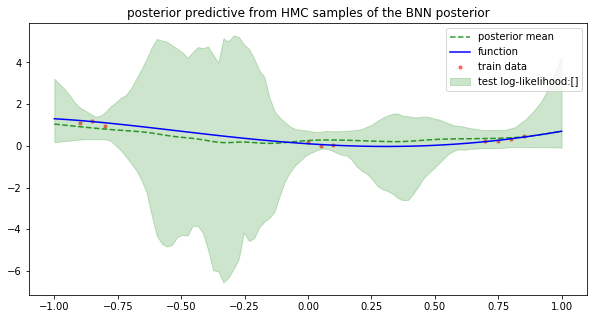

In [0]:
posterior_samples = HMC_sampler.trace[::100]
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape((1, -1))).reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape((1, -1))).reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_test)))

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y_data.shape[1]):
#    log_likelihood.append(gaussian_log_pdf(y_data[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
ub_bayes = np.percentile(y_pred_test, 97.5, axis=0)
lb_bayes = np.percentile(y_pred_test, 2.5, axis=0)
mean_bayes = np.mean(y_pred_test, axis=0)

#visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_bayes, lb_bayes, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from HMC samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

We see here that epistemic uncertainty is indeed most prevalent in the areas between the points; the gap between -0.75 and 0, espeecially, includes significant amounts of epistemic uncertainty where the model is extremely unsure what is going on.

We see that the HMC model does a pretty decent job at capturing the epistemic uncertainty which shrinks in data dense regions.

#### BBVI

Here we will try Black-Box Variational Inference (BBVI) as the sampling method (instead of dropout as the authors used), and compare it to our results from HMC.

In [0]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(log_joint, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 5000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -10 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

Optimizing variational parameters...
Iteration 0 lower bound -358.2821298930892; gradient mag: 201.445116865356
Iteration 5000 lower bound -21.239019485644647; gradient mag: 8.669624426374714
Iteration 10000 lower bound -30.96046803044728; gradient mag: 9.678693220013152
Iteration 15000 lower bound -30.914664542912575; gradient mag: 14.381074158604203
Iteration 20000 lower bound -21.13395770602405; gradient mag: 21.203682714346314


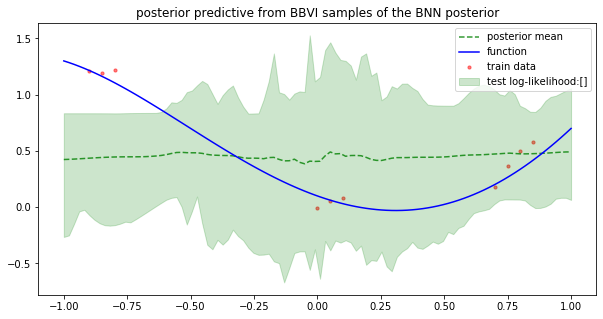

In [0]:
x_test = np.linspace(-8, 8, 100)
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1)).reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_test.reshape(1, -1)).reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_test)))

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
ub_bayes = np.percentile(y_pred_test, 97.5, axis=0)
lb_bayes = np.percentile(y_pred_test, 2.5, axis=0)
mean_bayes = np.mean(y_pred_test, axis=0)

#visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_bayes, lb_bayes, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

As we see here, a good BBVI run (we ran 45 times to get this) has a similar uncertainty shape as HMC. There's still the most concentrated epistemic error when there are no points, as we would expect.

### Modeling Heteroscedastic Aleatoric Uncertainty

Now let's implement the paper's model for heteroscedastic aleatoric uncertainty. This is achieved through introducing a measure of variance $\sigma^2_i$ for each input. The NN will then learn these $\sigma^2_i$ as outputs as well as variables in its loss function.

In [0]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        y_train = y_train[:1,:]
        #y_train = y_train[:,:int(0.5*y_train.shape[1])]
        #x_train1 = x_train[:,:int(0.5*x_train.shape[1])]
        
        if reg_param is None:
            
            def objective(W, t):
                #squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                pred = self.forward(W, x_train)
                y_pred = pred[:,:1,:]
                ss = pred[:,1:,:]
                #y_pred = pred[:,:,:int(0.5*pred.shape[2])]
                #ss = pred[:,:,int(0.5*pred.shape[2]):]
                squared_error = 1/2*np.exp(-ss)*np.linalg.norm(y_train - y_pred, axis=1)**2
                reg_term = 1/2*ss
                sum_error = np.sum(squared_error+reg_term)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']
        
        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 1000
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [0]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 2

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)


params = {'step_size':5e-3, 
          'max_iteration':10000, 
          'random_restarts':1}


Let us first consider the case where we only have a small number of samples, which are drawn with uniform noise from the polynomial model. We expect the model to have unreliable predictions of aleatoric uncertainty (except in data dense regions) due to this sparsity:

In [0]:
x = np.array([-1,-0.95,-0.9,-0.4,0.1,0.3,0.35,0.4,0.9,1])
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.25*np.ones(len(x)))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

Iteration 0 lower bound 10.347587572459622; gradient mag: 8.428040852853059
Iteration 1000 lower bound -27.513475742924182; gradient mag: 23.909603395593997
Iteration 2000 lower bound -31.812306660247376; gradient mag: 226.30790357915288
Iteration 3000 lower bound -32.03472944201945; gradient mag: 555.4066148362848
Iteration 4000 lower bound -33.468947019759675; gradient mag: 30.28255935704797
Iteration 5000 lower bound -34.85882740486732; gradient mag: 3.4590912686215365
Iteration 6000 lower bound -36.126317403050734; gradient mag: 91.31504024724266
Iteration 7000 lower bound -36.541611585927924; gradient mag: 5.201110867721682
Iteration 8000 lower bound -36.26191280334555; gradient mag: 5.954268513914018
Iteration 9000 lower bound -37.073844543226436; gradient mag: 5.809582773908568


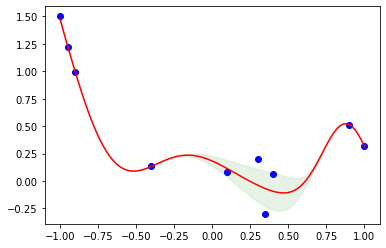

In [0]:
x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

Now we will look a data-dense model where we give it many training samples. We will do this for two cases:

1. Uniform noise for samples
2. Heterosedastic noise for samples of the form $\epsilon (x) = |x|/2$

Iteration 0 lower bound 4707122.775967083; gradient mag: 84463585.47173308
Iteration 1000 lower bound 4021.213944834246; gradient mag: 26637.29478419234
Iteration 2000 lower bound 1525.6755139983848; gradient mag: 8066.365687613586
Iteration 3000 lower bound 807.0453519722178; gradient mag: 3734.9646483404913
Iteration 4000 lower bound 467.30785583811434; gradient mag: 1985.5864830567318
Iteration 5000 lower bound 274.9442466116128; gradient mag: 1131.4512547578236
Iteration 6000 lower bound 154.627787344102; gradient mag: 675.396230395563
Iteration 7000 lower bound 75.44006472852963; gradient mag: 413.5995784218033
Iteration 8000 lower bound 23.03558671790153; gradient mag: 254.04221714538488
Iteration 9000 lower bound -10.803137536652478; gradient mag: 153.9303582996743


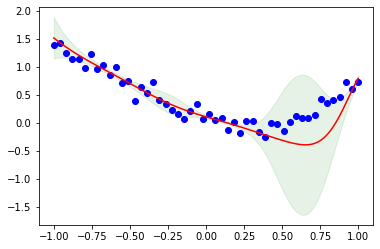

In [0]:
x = np.linspace(-1,1,50)
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.1*np.ones(len(x)))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

As we can see, when we have more data, the aleatoric uncertainty model does a much better job at finding the noise from the model. For the most part, the model does a decent job at approximating the uniform noise/uncertainty.

Next, let's try the more complicated case where the noise varies with $x$:

Iteration 0 lower bound 9423.520156177432; gradient mag: 127188.98320637285
Iteration 1000 lower bound 12.13989154877624; gradient mag: 57.966267019813905
Iteration 2000 lower bound -12.51038039606655; gradient mag: 55.57194790466637
Iteration 3000 lower bound -39.35977027278068; gradient mag: 28.406151083659182
Iteration 4000 lower bound -46.366400334268484; gradient mag: 13.42423158912157
Iteration 5000 lower bound -51.23171444880909; gradient mag: 8.36671151924617
Iteration 6000 lower bound -56.02015608985887; gradient mag: 5.457101735852053
Iteration 7000 lower bound -59.37839339058104; gradient mag: 3.0041983991355985
Iteration 8000 lower bound -61.18401387183387; gradient mag: 112.05025806061894
Iteration 9000 lower bound -62.39321713962163; gradient mag: 204.66353647433243


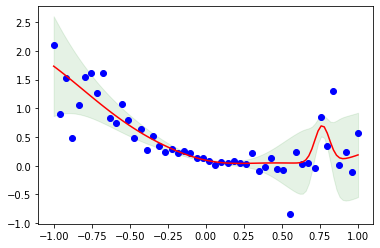

In [0]:
x = np.linspace(-1,1,50)
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.5*np.abs(x))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

Great! It looks like our heteroscedastic aleatoric uncertainty model has picked up on the blowing up behavior of the sampling noise as $|x|$ becomes larger than zero. We can see this in the increasing green area width as we move further from $x=0$.

### Combined Uncertainty Model

Now we are ready to combine the two modeling approaches to make a model of both forms of uncertainty. This is achieved by placing a distribution over the weights (i.e. BNN) and then adding a $\sigma^2$ term to the loss function and outputs (as we did in the aleatoric model). The overall variance is computed using Monte Carlo as:

$$ \text{Var}(y) \approx \frac{1}{T} \sum_{t=1}^T \hat{y}_t^2 - \left( \frac{1}{T} \sum_{t=1}^T \hat{y}_t \right)^2 + \frac{1}{T} \sum_{t=1}^T \sigma_t^2$$

In [0]:
def total_variance (samples_y, samples_s):
  # function for calcuating the total variance from MC samples of y and sigma^2
  T = len(samples_y) # number of samples
  samples_s = [np.exp(s) for s in samples_s]
  variance1 = 1/T*np.sum(np.array([y**2 for y in samples_y]),axis=0)
  variance2 = (1/T*np.sum(np.array([y for y in samples_y]),axis=0))**2
  variance3 = 1/T*np.sum(np.array([s for s in samples_s]),axis=0)
  return (variance1-variance2+variance3)

In [0]:
def test_objective(W, t):
  #squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
  pred = nn.forward(W, x.reshape((1, 1, x.shape[0])))
  y_pred = pred[:,:1,:]
  ss = pred[:,1:,:]
  #y_pred = pred[:,:,:int(0.5*pred.shape[2])]
  #ss = pred[:,:,int(0.5*pred.shape[2]):]
  squared_error = 1/2*np.exp(-ss)*np.linalg.norm(y - y_pred, axis=1)**2
  reg_term = 1/2*ss
  sum_error = np.sum(squared_error+reg_term)
  return -sum_error
            
grad_test_obj = grad(test_objective)

We first run with sparse data to test to see if the combined model works well for apturing epistemic uncertainty (due to lack of data):

In [0]:
x = np.array([-1,-0.95,-0.9,-0.4,0.1,0.3,0.35,0.4,0.9,1])
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.25*np.ones(len(x)))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(test_objective, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 1000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -50 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

In [0]:
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_range)))
y_pred_sigma = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,1:,:].reshape((total_samples, -1))
tvar = total_variance(y_pred_test, y_pred_sigma)

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
mean_bayes = np.mean(y_pred_test, axis=0)
ub_new = mean_bayes + np.sqrt(tvar)
lb_new = mean_bayes - np.sqrt(tvar)

#visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_new, lb_new, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

With just a few points, it was quite noisy which is indicative of epistemic uncertainty, especially since the uncertainity decreases around the point-dense regions.

Now for more data where we shrink epistemic uncertainity and see if the model can capture homoscedastic aleatoric uncertainity (i.e. uniform noise):

In [0]:
x = np.linspace(-1,1,50)
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.1*np.ones(len(x)))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(test_objective, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 1000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -50 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

Optimizing variational parameters...
Iteration 0 lower bound -219783.8836462521; gradient mag: 95424.73720098897
Iteration 1000 lower bound 147025.9640746526; gradient mag: 104.13642729155968
Iteration 2000 lower bound 147228.93778001657; gradient mag: 25093.15928358899
Iteration 3000 lower bound 148376.04147611413; gradient mag: 1819.2976654897384
Iteration 4000 lower bound 229903.03074782962; gradient mag: 2797.6719657415783
Iteration 5000 lower bound 231777.64125562715; gradient mag: 5427.866169734078
Iteration 6000 lower bound 232649.01077053347; gradient mag: 29063.087549240827
Iteration 7000 lower bound 235411.50220706957; gradient mag: 87905.91020928478
Iteration 8000 lower bound 237610.1736953853; gradient mag: 159277.13858517594
Iteration 9000 lower bound 239139.82198205483; gradient mag: 6179.571902749985
Iteration 10000 lower bound 240026.07099189304; gradient mag: 418026.8989733417
Iteration 11000 lower bound 240924.91284277415; gradient mag: 265017.79726178857
Iteration 12

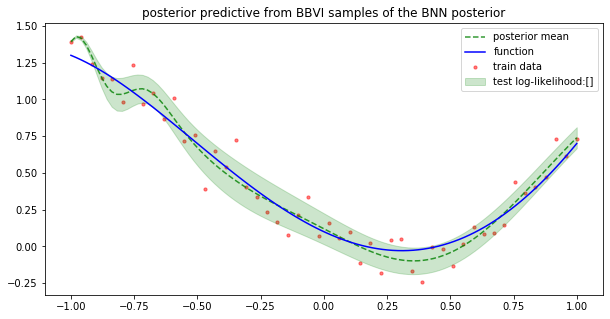

In [0]:
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_range)))
y_pred_sigma = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,1:,:].reshape((total_samples, -1))
tvar = total_variance(y_pred_test, y_pred_sigma)

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
mean_bayes = np.mean(y_pred_test, axis=0)
ub_new = mean_bayes + np.sqrt(tvar)
lb_new = mean_bayes - np.sqrt(tvar)

#visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_new, lb_new, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

As we can see above, the width is essentially uniform throughout meaning that our combined model is picking up on the simplest case of aleatoric uncertainity!

We now run on heteroscedastic data to test a more complicated case:

Iteration 0 lower bound 328.22975127616047; gradient mag: 1687.5241464039643
Iteration 1000 lower bound -52.8244912965864; gradient mag: 2.527789551192483
Iteration 2000 lower bound -54.444711868925104; gradient mag: 2.3523931787291077
Iteration 3000 lower bound -55.924879064020075; gradient mag: 1.2342356409595512
Iteration 4000 lower bound -57.453878270836384; gradient mag: 1.1949685382478388
Iteration 5000 lower bound -59.687110477945026; gradient mag: 5.055754027828099
Iteration 6000 lower bound -61.08473895041333; gradient mag: 25.353821787523426
Iteration 7000 lower bound -62.08458267697825; gradient mag: 213.47377334733648
Iteration 8000 lower bound -62.53249159320217; gradient mag: 206.6733234976798
Iteration 9000 lower bound -55.325161670662034; gradient mag: 8522.439270672201


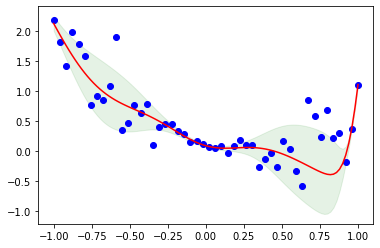

In [0]:
x = np.linspace(-1,1,50)
coeffs = [0.1,-0.8,1.1,0.5,-0.2]
y = poly(x, coeffs, 0.5*np.abs(x))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(test_objective, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 1000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -50 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

Optimizing variational parameters...
Iteration 0 lower bound -220471.09001544156; gradient mag: 95405.3838901225
Iteration 1000 lower bound 71963.72765884268; gradient mag: 184.85303043412222
Iteration 2000 lower bound 72193.36380647875; gradient mag: 4.690415773791031
Iteration 3000 lower bound 72413.36380427878; gradient mag: 4.6904158466432095
Iteration 4000 lower bound 77906.8621272327; gradient mag: 6917.952068569415
Iteration 5000 lower bound 139667.7877168925; gradient mag: 100622.28859130446
Iteration 6000 lower bound 140180.6583040346; gradient mag: 45542.26639271122
Iteration 7000 lower bound 142822.07006834436; gradient mag: 50922.03485532694
Iteration 8000 lower bound 145339.28000270037; gradient mag: 48989.38141307475
Iteration 9000 lower bound 150957.4893625271; gradient mag: 57547.4355550166
Iteration 10000 lower bound 166847.50677459445; gradient mag: 800388.112947868
Iteration 11000 lower bound 172571.9862790498; gradient mag: 203222.71027870095
Iteration 12000 lower b

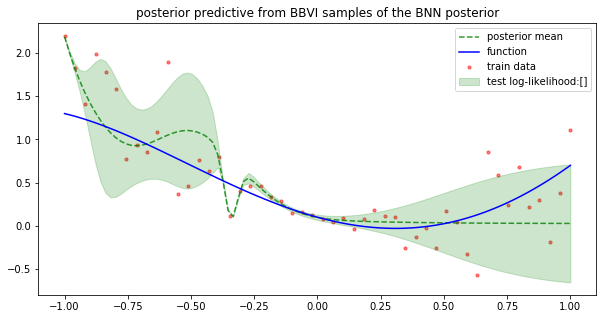

In [0]:
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_range)))
y_pred_sigma = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,1:,:].reshape((total_samples, -1))
tvar = total_variance(y_pred_test, y_pred_sigma)

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
mean_bayes = np.mean(y_pred_test, axis=0)
ub_new = mean_bayes + np.sqrt(tvar)
lb_new = mean_bayes - np.sqrt(tvar)

#visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_new, lb_new, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

Again, we see that the combined model does an admirable job at modeling aleatoric uncertainity--in this case, it aptly captures to divergent trend of the uncertainity as we add error proportionally to $|x|$.

### Failure Regimes

Finally, we will showcase some examples where one or both of the uncertainty measrements are counterintuitive or not reflective of the underlying polynomial function.

The first example to investigate are highly oscillatory functions where insufficient data or sufficiently large aleatoric uncertainity (i.e. noise) will cause the BNN to have trouble in correctly estimating the function and/or estimating the uncertainty trends.

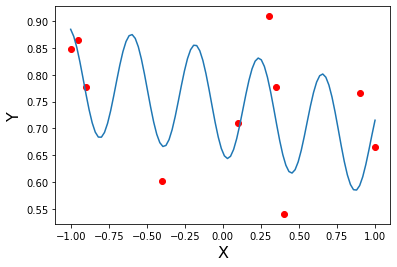

In [0]:
def notpoly(x, coeffs, noise): # function for making our toy not polynomial
    polys = []
    for i, xd in enumerate(x):
        summed = np.sum([coeffs[i][0]*np.sin(coeffs[i][1] * xd - coeffs[i][2]) for i in range(len(coeffs))])
        noised = summed + np.random.normal(0,noise[i])
        polys.append(noised)
    return (np.array(polys))
    
x = np.array([-1,-0.95,-0.9,-0.4,0.1,0.3,0.35,0.4,0.9,1])
coeffs = [[0.1, 15, 2], [-0.8, 0.2, 1.2]]
y = notpoly(x, coeffs, 0.1*np.ones(len(x)));

x_space = np.linspace(-1,1,100)
y_space = notpoly(x_space, coeffs, np.zeros(len(x_space)))

plt.plot(x,y,'ro',linewidth=0,label='samples')
plt.plot(x_space,y_space,label='samples')
plt.xlabel('X',fontsize=16)
plt.ylabel('Y',fontsize=16)
plt.show()

Now we run the model:

In [0]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        y_train = y_train[:1,:]
        #y_train = y_train[:,:int(0.5*y_train.shape[1])]
        #x_train1 = x_train[:,:int(0.5*x_train.shape[1])]
        
        if reg_param is None:
            
            def objective(W, t):
                #squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                pred = self.forward(W, x_train)
                y_pred = pred[:,:1,:]
                ss = pred[:,1:,:]
                #y_pred = pred[:,:,:int(0.5*pred.shape[2])]
                #ss = pred[:,:,int(0.5*pred.shape[2]):]
                squared_error = 1/2*np.exp(-ss)*np.linalg.norm(y_train - y_pred, axis=1)**2
                reg_term = 1/2*ss
                sum_error = np.sum(squared_error+reg_term)
                return sum_error
            
            return objective, grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']
        
        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 1000
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [0]:
###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 2

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)


params = {'step_size':5e-3, 
          'max_iteration':10000, 
          'random_restarts':1}

Iteration 0 lower bound 11.858416936131407; gradient mag: 11.328682990574823
Iteration 1000 lower bound -25.68953577580502; gradient mag: 74.88774296991183
Iteration 2000 lower bound -34.46767373695892; gradient mag: 520.4006860264536
Iteration 3000 lower bound -35.38735637195152; gradient mag: 242.02462793909058
Iteration 4000 lower bound -36.46478668106745; gradient mag: 3.7738856233054863
Iteration 5000 lower bound -37.34270198585112; gradient mag: 7.1532272607962115
Iteration 6000 lower bound -36.27386412640219; gradient mag: 146.04930874572605
Iteration 7000 lower bound -36.55686203203403; gradient mag: 22.68646382972897
Iteration 8000 lower bound -37.823961188582594; gradient mag: 4.419686709225971
Iteration 9000 lower bound -37.66506907039407; gradient mag: 4.1718395814609215


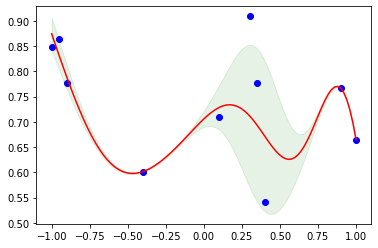

In [0]:
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(test_objective, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 1000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -50 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

Optimizing variational parameters...
Iteration 0 lower bound -43430.252933052485; gradient mag: 18617.400615970084
Iteration 1000 lower bound 52557.488968320016; gradient mag: 244.17934515226293
Iteration 2000 lower bound 52914.24838362888; gradient mag: 9538.183233942393
Iteration 3000 lower bound 53231.07184754939; gradient mag: 1297.053804324508
Iteration 4000 lower bound 55079.40407311541; gradient mag: 334251.8179793709
Iteration 5000 lower bound 57386.524134650135; gradient mag: 121811.4665352729
Iteration 6000 lower bound 58423.815079513864; gradient mag: 381907.7226005386
Iteration 7000 lower bound 53051.177855972746; gradient mag: 62359.183347767845
Iteration 8000 lower bound 59525.88835004901; gradient mag: 15495.283177193067
Iteration 9000 lower bound 54945.54887977397; gradient mag: 48914.12789445228
Iteration 10000 lower bound 60167.42259575123; gradient mag: 132370.67038809505
Iteration 11000 lower bound 60307.30808046601; gradient mag: 490981.57810507505
Iteration 12000 

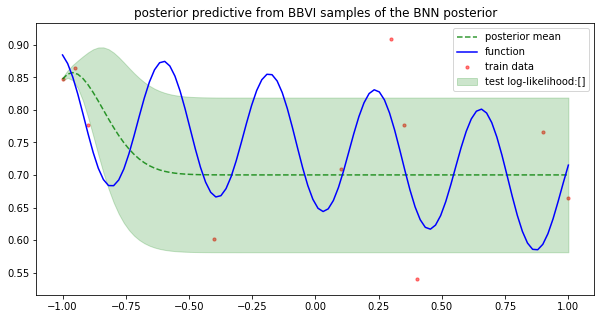

In [0]:
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_range)))
y_pred_sigma = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,1:,:].reshape((total_samples, -1))
tvar = total_variance(y_pred_test, y_pred_sigma)

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
mean_bayes = np.mean(y_pred_test, axis=0)
ub_new = mean_bayes + np.sqrt(tvar)
lb_new = mean_bayes - np.sqrt(tvar)

#visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_new, lb_new, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

With this new function with oscillation, it is clear that the model is no longer ideal. It predicts significant error everywhere. At this point, we don't know if it's focusing on epistemic or aleatoric error; we need more data points and do this below:

Iteration 0 lower bound 97382.07415789927; gradient mag: 954994.7758530584
Iteration 1000 lower bound 36.25119277997586; gradient mag: 464.86131741299374
Iteration 2000 lower bound -22.573308176936393; gradient mag: 130.62783220526973
Iteration 3000 lower bound -34.69469803748362; gradient mag: 55.26541345359582
Iteration 4000 lower bound -39.36431956849735; gradient mag: 32.06364639596508
Iteration 5000 lower bound -42.867250438336185; gradient mag: 23.05722734022458
Iteration 6000 lower bound -47.21840141601144; gradient mag: 21.827499304311935
Iteration 7000 lower bound -54.78282536198924; gradient mag: 22.01733196667869
Iteration 8000 lower bound -64.29840034041206; gradient mag: 15.360347616582716
Iteration 9000 lower bound -70.1766047936115; gradient mag: 7.295972674309255


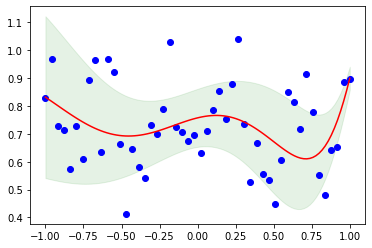

In [0]:
x = np.linspace(-1,1,50)
coeffs = [[0.1, 15, 2], [-0.8, 0.2, 1.2]]
y = notpoly(x, coeffs, 0.1*np.ones(len(x)))
y_s = np.zeros(len(y)) # Fillers for s, doesn't really matter

nn.fit(x.reshape((1, -1)), np.vstack((y,y_s)).reshape((2, -1)), params)
w = nn.weights

x_range = np.linspace(-1,1,100)
y_pred = nn.forward(w, x_range.reshape((1, -1)))
sigma2_pred = np.exp(y_pred[0,1,:])
sigma_pred = np.sqrt(sigma2_pred)

plt.plot(x,y,'bo',linewidth=0)
plt.plot(x_range,y_pred[0,0,:],'r')
plt.fill_between(x_range,y_pred[0,0,:]-sigma_pred,y_pred[0,0,:]+sigma_pred,color='g',alpha=0.1)
plt.show()

In [0]:
# Build variational objective
D = nn.D
objective, gradient, unpack_params = black_box_variational_inference(test_objective, D, num_samples=50)
verbose = True

def callback_bbvi(params, t, g):
  if verbose:
    if  t % 1000 == 0:
      print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

print("Optimizing variational parameters...")
#initialize variational parameters
init_mean = np.ones(D)
init_log_std = -50 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
    
#perform gradient descent using adam (a type of gradient-based optimizer)
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=20001, callback=callback_bbvi)

var_means = variational_params[:D]
var_variance = np.diag(np.exp(variational_params[D:])**2)

Optimizing variational parameters...
Iteration 0 lower bound -211202.68883628174; gradient mag: 102374.34150642212
Iteration 1000 lower bound 173989.79470071802; gradient mag: 57.67987109011622
Iteration 2000 lower bound 174814.84744782702; gradient mag: 79.77020320268666
Iteration 3000 lower bound 175017.64677934398; gradient mag: 24361.159633317067
Iteration 4000 lower bound 175276.8777606282; gradient mag: 4219.134028293663
Iteration 5000 lower bound 175361.7404260989; gradient mag: 11624.293787625491
Iteration 6000 lower bound 175375.22617420612; gradient mag: 9430.05435676955
Iteration 7000 lower bound 175424.84434528052; gradient mag: 11480.951053486897
Iteration 8000 lower bound 177890.92611916814; gradient mag: 2259.8994665327227
Iteration 9000 lower bound 190270.73787574505; gradient mag: 5172.066318995354
Iteration 10000 lower bound 191205.17453087846; gradient mag: 7058.594982860153
Iteration 11000 lower bound 191737.9017406552; gradient mag: 6165.56746091503
Iteration 12000

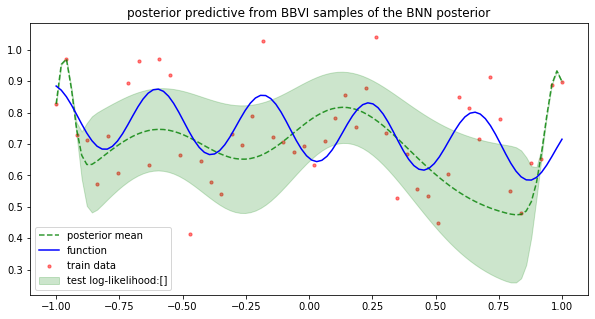

In [0]:
posterior_sample_size = 100

posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)
total_samples = len(posterior_samples)

y_predict_data_noiseless = nn.forward(posterior_samples, x.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))
y_pred_test = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,:1,:].reshape((total_samples, -1))# + np.random.normal(0, sigma_y**0.5, size=(total_samples, len(x_range)))
y_pred_sigma = nn.forward(posterior_samples, x_range.reshape(1, -1))[:,1:,:].reshape((total_samples, -1))
tvar = total_variance(y_pred_test, y_pred_sigma)

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute log likelihood for the training data
#log_likelihood = []
#for n in range(y.shape[0]):
#    log_likelihood.append(gaussian_log_pdf(y[:, n], sigma_y,  y_predict_data_noiseless[:, n].flatten()).mean())
#log_likelihood = np.array(log_likelihood).sum()

#compute the 95 percentiles and the mean of the posterior predictives
mean_bayes = np.mean(y_pred_test, axis=0)
ub_new = mean_bayes + np.sqrt(tvar)
lb_new = mean_bayes - np.sqrt(tvar)

#visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x.flatten(), y.flatten(), color='red', s=10, alpha=0.5, label='train data')
ax.plot(x_range.flatten(), mean_bayes, '--', color='green', alpha=0.8, label='posterior mean')
ax.fill_between(x_range.flatten(), ub_new, lb_new, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
ax.plot(x_space, y_space, color='blue', label='function')

ax.set_title('posterior predictive from BBVI samples of the BNN posterior')
ax.legend(loc='best')
plt.show()

As we can see the model does not do the ideal job of capturing the high frequency oscillations in uncertainty that is in the model. Instead the model fits a lowe frequency equation with somehat uniform uncertainty throughout. 

In summary, we have considered a few examples (in this section and also previously in the model implementations) where the combined uncertainty model does a poor job at approximating the underlying uncertainty of the model:
1. Aleatoric uncertainty is poorly estimated when the training data is small.
2. Both aleatoric and epistemic uncertainty is poorly estimated when the underlying model is a high-frequency sinusoid (i.e. oscillates rapidly)
3. Aleatoric uncertainty is poorly estimated when the model's noise oscillates rapidly for different $x$. This is estimated as a uniform or monotonic $\sigma(x)$ instead of oscillating $\sigma(x)$.